# 3D Gan Interpolation

based on : https://github.com/rp2707/coms4995-project/tree/master/multicategory

In [1]:
%matplotlib inline

import pickle

import os
import sys
import visdom
import logger
sys.path.append('GAN')

import numpy as np
import tensorflow as tf

from tqdm import *
from utils.utils import *
import utils.dataIO as d

'''
Global Parameters
'''
n_epochs   = 20205
batch_size = 32
g_lr       = 0.00025
d_lr       = 0.00001
beta       = 0.5
momentum   = 0.9
d_thresh   = 0.8
z_size     = 200
leak_value = 0.2
obj_ratio  = 0.7

cube_len    = 64
cube_channel= 1

f_dim      = 64

model_name = 'biasfree_tfbn'
summary_dir = './summary/'
train_sample_directory = './train_sample/'
model_directory = './models/'
is_local = False

weights, biases = {}, {}
def generator(z, batch_size=batch_size, phase_train=True, reuse=False):

    strides    = [1,2,2,2,1]

    with tf.variable_scope("gen", reuse=reuse):
        z = tf.reshape(z, (batch_size, 1, 1, 1, z_size))
        g_1 = tf.nn.conv3d_transpose(z, weights['wg1'], (batch_size,4,4,4,512), strides=[1,1,1,1,1], padding="VALID")
        g_1 = tf.layers.batch_normalization(g_1, training=phase_train, epsilon=1e-4, momentum=0.9)
        g_1 = tf.nn.relu(g_1)
        print ('G1: ', g_1)

        g_2 = tf.nn.conv3d_transpose(g_1, weights['wg2'], (batch_size,8,8,8,256), strides=strides, padding="SAME")
        g_2 = tf.layers.batch_normalization(g_2, training=phase_train, epsilon=1e-4, momentum=0.9)
        g_2 = tf.nn.relu(g_2)
        print ('G2: ', g_2)

        g_3 = tf.nn.conv3d_transpose(g_2, weights['wg3'], (batch_size,16,16,16,128), strides=strides, padding="SAME")
        g_3 = tf.layers.batch_normalization(g_3, training=phase_train, epsilon=1e-4, momentum=0.9)
        g_3 = tf.nn.relu(g_3)
        print ('G3: ', g_3)

        g_4 = tf.nn.conv3d_transpose(g_3, weights['wg4'], (batch_size,32,32,32,64), strides=strides, padding="SAME")
        g_4 = tf.layers.batch_normalization(g_4, training=phase_train, epsilon=1e-4, momentum=0.9)
        g_4 = tf.nn.relu(g_4)
        print ('G4: ', g_4)

        g_5 = tf.nn.conv3d_transpose(g_4, weights['wg5'], (batch_size,64,64,64,1), strides=strides, padding="SAME")
        g_5 = tf.nn.tanh(g_5)
        print ('G5: ', g_5)

    return g_5


def discriminator(inputs, phase_train=True, reuse=False):

    strides    = [1,2,2,2,1]
    with tf.variable_scope("dis", reuse=reuse):
        d_1 = tf.nn.conv3d(inputs, weights['wd1'], strides=strides, padding="SAME")
        d_1 = lrelu(d_1, leak_value)
        print ('D1: ', d_1)

        d_2 = tf.nn.conv3d(d_1, weights['wd2'], strides=strides, padding="SAME") 
        d_2 = tf.layers.batch_normalization(d_2, training=phase_train, epsilon=1e-4, momentum=0.9)
        d_2 = lrelu(d_2, leak_value)
        print ('D2: ', d_2)

        d_3 = tf.nn.conv3d(d_2, weights['wd3'], strides=strides, padding="SAME")  
        d_3 = tf.layers.batch_normalization(d_3, training=phase_train, epsilon=1e-4, momentum=0.9)
        d_3 = lrelu(d_3, leak_value) 
        print ('D3: ', d_3)

        d_4 = tf.nn.conv3d(d_3, weights['wd4'], strides=strides, padding="SAME")     
        d_4 = tf.layers.batch_normalization(d_4, training=phase_train, epsilon=1e-4, momentum=0.9)
        d_4 = lrelu(d_4)
        print ('D4: ', d_4)


        d_5 = tf.nn.conv3d(d_4, weights['wd5'], strides=[1,1,1,1,1], padding="VALID")
        d_5_no_sigmoid = d_5
        d_5 = tf.nn.sigmoid(d_5)
        print ('D5: ', d_5)

    return d_5, d_5_no_sigmoid

# --- [ Initialize Global Variables: strides, sizes, weights, biases
def init():

    global strides, s, s2, s4, s8, s16

    strides    = [1,2,2,2,1]

    s   = int(cube_len)  #64
    s2  = int(np.ceil(float(s) / float(strides[1])))    #32
    s4  = int(np.ceil(float(s2) / float(strides[1])))   #16
    s8  = int(np.ceil(float(s4) / float(strides[1])))   #8
    s16 = int(np.ceil(float(s8) / float(strides[1])))   #4

    initializeWeights()

def initializeWeights():

    global weights
    xavier_init = tf.contrib.layers.xavier_initializer()

    weights['wg1'] = tf.get_variable("wg1", shape=[4, 4, 4, 512, 200], initializer=xavier_init)
    weights['wg2'] = tf.get_variable("wg2", shape=[4, 4, 4, 256, 512], initializer=xavier_init)
    weights['wg3'] = tf.get_variable("wg3", shape=[4, 4, 4, 128, 256], initializer=xavier_init)
    weights['wg4'] = tf.get_variable("wg4", shape=[4, 4, 4, 64, 128], initializer=xavier_init)
    weights['wg5'] = tf.get_variable("wg5", shape=[4, 4, 4, 1, 64], initializer=xavier_init)

    weights['wd1'] = tf.get_variable("wd1", shape=[4, 4, 4, 1, 64], initializer=xavier_init)
    weights['wd2'] = tf.get_variable("wd2", shape=[4, 4, 4, 64, 128], initializer=xavier_init)
    weights['wd3'] = tf.get_variable("wd3", shape=[4, 4, 4, 128, 256], initializer=xavier_init)
    weights['wd4'] = tf.get_variable("wd4", shape=[4, 4, 4, 256, 512], initializer=xavier_init)
    weights['wd5'] = tf.get_variable("wd5", shape=[4, 4, 4, 512, 1], initializer=xavier_init)

    return weights

# ---
def initialiseBiases():

    global biases
    zero_init = tf.zeros_initializer()

    biases['bg1'] = tf.get_variable("bg1", shape=[512], initializer=zero_init)
    biases['bg2'] = tf.get_variable("bg2", shape=[256], initializer=zero_init)
    biases['bg3'] = tf.get_variable("bg3", shape=[128], initializer=zero_init)
    biases['bg4'] = tf.get_variable("bg4", shape=[64], initializer=zero_init)
    biases['bg5'] = tf.get_variable("bg5", shape=[1], initializer=zero_init)

    biases['bd1'] = tf.get_variable("bd1", shape=[64], initializer=zero_init)
    biases['bd2'] = tf.get_variable("bd2", shape=[128], initializer=zero_init)
    biases['bd3'] = tf.get_variable("bd3", shape=[256], initializer=zero_init)
    biases['bd4'] = tf.get_variable("bd4", shape=[512], initializer=zero_init)
    biases['bd5'] = tf.get_variable("bd5", shape=[1], initializer=zero_init)

    return biases
# --- ]

def trainGAN(is_dummy=False, checkpoint=None, name=model_name):

    init()

    global_step = tf.get_variable('global_step', shape=[], initializer=tf.zeros_initializer(), dtype=tf.int32)

    z_vector = tf.placeholder(shape=[batch_size,z_size],dtype=tf.float32) 
    x_vector = tf.placeholder(shape=[batch_size,cube_len,cube_len,cube_len,cube_channel],dtype=tf.float32)

    net_g_train = generator(z_vector, phase_train=True, reuse=False) 
    net_g_test  = generator(z_vector, phase_train=False, reuse=True)
    print ('G train: ', net_g_train)
    print ('G test: ', net_g_test)

    d_output_ax, d_output_x = discriminator(x_vector, phase_train=True, reuse=False)
    d_output_ax = tf.clip_by_value(d_output_ax, 0.01, 0.99)

    d_output_az, d_output_z = discriminator(net_g_train, phase_train=True, reuse=True)
    d_output_az = tf.clip_by_value(d_output_az, 0.01, 0.99)

    print ('D_output_x: ', d_output_x)
    print ('D_output_z: ', d_output_z)
    n_p_x = tf.reduce_sum(tf.cast(d_output_ax > 0.5, tf.int32))  # hope all d_output_ax ~ 1
    n_p_z = tf.reduce_sum(tf.cast(d_output_az <= 0.5, tf.int32)) # hope all d_output_az ~ 0
    d_acc = tf.divide( n_p_x + n_p_z, 2 * np.prod(d_output_ax.shape.as_list()) )

    d_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_output_x, labels=tf.ones_like(d_output_x)) + \
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_output_z, labels=tf.zeros_like(d_output_z))
    g_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=d_output_z, labels=tf.ones_like(d_output_z))
    d_loss = tf.reduce_mean(d_loss)
    g_loss = tf.reduce_mean(g_loss)


    net_g_test = generator(z_vector, phase_train=False, reuse=True)

    para_g = [var for var in tf.trainable_variables() if any(x in var.name for x in ['wg', 'bg', 'gen'])]
    para_d = [var for var in tf.trainable_variables() if any(x in var.name for x in ['wd', 'bd', 'dis'])]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer_op_d = tf.train.AdamOptimizer(learning_rate=d_lr,beta1=beta).minimize(d_loss,var_list=para_d)
        optimizer_op_g = tf.train.AdamOptimizer(learning_rate=g_lr,beta1=beta).minimize(g_loss,var_list=para_g)

    saver = tf.train.Saver(tf.global_variables(), max_to_keep=20)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True

    with tf.Session(config=config) as sess:

        sess.run(tf.global_variables_initializer())

        if checkpoint is not None:
            saver.restore(sess, checkpoint)
            epoch = sess.run(global_step)
            sess.run(tf.assign(global_step, epoch + 1))

        if is_dummy:
            volumes = np.random.randint(0,2,(batch_size,cube_len,cube_len,cube_len))
            print ('Using Dummy Data')
        else:
            volumes = d.getAll(obj=obj, train=True, is_local=is_local, obj_ratio=obj_ratio)
            print ('Using ' + obj + ' Data')
        volumes = volumes[...,np.newaxis].astype(np.float32)

        z_val = np.random.normal(0, 0.33, size=[batch_size, z_size]).astype(np.float32)

        for epoch in range(sess.run(global_step), n_epochs):

            idx = np.random.randint(len(volumes), size=batch_size)
            x = volumes[idx]
            z = np.random.normal(0, 0.33, size=[batch_size, z_size]).astype(np.float32)
            _,  discriminator_loss = sess.run([optimizer_op_d,d_loss],feed_dict={z_vector:z, x_vector:x})
            _,  generator_loss = sess.run([optimizer_op_g,g_loss],feed_dict={z_vector:z, x_vector:x}) 
            d_accuracy, n_x, n_z = sess.run([d_acc, n_p_x, n_p_z],feed_dict={z_vector:z, x_vector:x})
            print ("# of (D(x) > 0.5) : ", n_x)
            print ("# of (D(G(z)) <= 0.5) : ", n_z)
            print ('Discriminator Training ', "epoch: ",epoch,', d_loss:',discriminator_loss,'g_loss:',generator_loss, "d_acc: ", d_accuracy)
            print ('Generator Training ', "epoch: ",epoch,', d_loss:',discriminator_loss,'g_loss:',generator_loss, "d_acc: ", d_accuracy)

            if d_accuracy < d_thresh:
                _, discriminator_loss = sess.run([optimizer_op_d,d_loss],feed_dict={z_vector:z, x_vector:x})
                d_accuracy = sess.run(d_acc,feed_dict={z_vector:z, x_vector:x})
                print ('Discriminator Training ', "epoch: ",epoch,', d_loss:',discriminator_loss,'g_loss:',generator_loss, "d_acc: ", d_accuracy)

            if epoch % 200 == 0:
                g_objects = sess.run(net_g_test,feed_dict={z_vector:z_val}) #type=np.ndarray
                if not os.path.exists(train_sample_directory):
                    os.makedirs(train_sample_directory)
                g_objects.dump(os.path.join(train_sample_directory, '{}_{}.pkl'.format(model_name, epoch)))
                id_ch = np.random.randint(0, batch_size, 4)

            if epoch % 200 == 0:
                if not os.path.exists(model_directory):
                    os.makedirs(model_directory)
                saver.save(sess, save_path = os.path.join(model_directory, '{}.ckpt'.format(model_name)), global_step=global_step)

            sess.run(tf.assign(global_step, epoch + 1))


def testGAN(trained_model_path=None, n_batches=2, z_vector_path=None):
    init()
    
    savename='save-16K'
    
    
    z_vector = tf.placeholder(shape=[batch_size,z_size],dtype=tf.float32) 
    net_g_test = generator(z_vector, phase_train=True, reuse=False)
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, trained_model_path) 

        if z_vector_path:
            savename += '__interpolated_results'
            z_sample = np.load(z_vector_path).astype(np.float32) #shape is Npoints x 200, using Npoints=batchsize (32)
            g_out = sess.run(net_g_test,feed_dict={z_vector:z_sample})
            z_out = z_sample
        else:
            for j in range(n_batches):
                next_sigma = 0.33 # float(raw_input())
                z_sample = np.random.normal(0, next_sigma, size=[batch_size, z_size]).astype(np.float32)
                g_objects = sess.run(net_g_test,feed_dict={z_vector:z_sample})
            
                if j==0:
                    g_out = g_objects
                    z_out = z_sample
                else:
                    g_out = np.vstack((g_out,g_objects))
                    z_out = np.vstack((z_out,z_sample))
        np.save('output/{0}.npy'.format(savename), g_out)
        np.save('output/{}_zvectors.npy'.format(savename),z_out)


All dependencies not loaded, some functionality may not work


# Loading

loading pretrained model and setting random seed for reproducable results and initialize network

In [2]:
trained_model_path= "./GAN/models/biasfree_tfbn.ckpt-18400"
n_batches=2
np.random.seed(42)
tf.set_random_seed(24)
init()



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[21/May/2019 20:34:49] WARNING - From /usr/local/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


# Generate z vectors

Function to generate random z-vectors

In [3]:
def genzvectors():
    z_vector = tf.placeholder(shape=[batch_size,z_size],dtype=tf.float32)
    net_g_test = generator(z_vector, phase_train=True, reuse=False)
    saver = tf.train.Saver()
    g_out = z_out = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, trained_model_path)
        for j in range(n_batches):
                next_sigma = 0.33 # float(raw_input())
                z_sample = np.random.normal(0, next_sigma, size=[batch_size, z_size]).astype(np.float32)
                g_objects = sess.run(net_g_test,feed_dict={z_vector:z_sample})
                if j==0:
                    g_out = g_objects
                    z_out = z_sample
                else:
                    g_out = np.vstack((g_out,g_objects))
                    z_out = np.vstack((z_out,z_sample))
    return {"g_out": g_out, "z_out": z_out}

# Plotting

function to plot the 3D volumetric objects

In [4]:
import matplotlib.pyplot as plt
def plot(arr):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.voxels((arr>0.7),antialiased=False, linewidth=0.0)
    plt.show()

# generate samples

generate some samples

In [5]:
out = genzvectors()
g_out = out["g_out"]
z_out = out["z_out"]

[21/May/2019 20:34:49] WARNING - From <ipython-input-1-5365a0a637d0>:51: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.batch_normalization instead.
G1:  Tensor("gen/Relu:0", shape=(32, 4, 4, 4, 512), dtype=float32)
G2:  Tensor("gen/Relu_1:0", shape=(32, 8, 8, 8, 256), dtype=float32)
G3:  Tensor("gen/Relu_2:0", shape=(32, 16, 16, 16, 128), dtype=float32)
G4:  Tensor("gen/Relu_3:0", shape=(32, 32, 32, 32, 64), dtype=float32)
G5:  Tensor("gen/Tanh:0", shape=(32, 64, 64, 64, 1), dtype=float32)
[21/May/2019 20:34:49] WARNING - From /usr/local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
[21/May/2019 20:34:49] INFO - Restoring parameters 

# visualize some samples

fix 3 z-vectors that "look good"

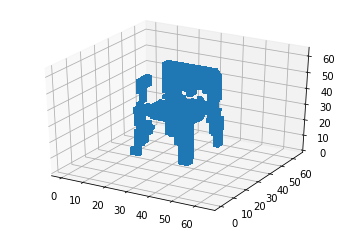

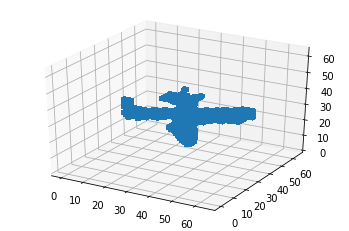

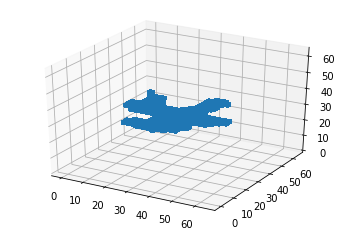

In [6]:
z1 = 25
z2 = 5
z3 = 3

plot(np.asarray(g_out)[z1].reshape(64,64,64))
plot(np.asarray(g_out)[z2].reshape(64,64,64))
plot(np.asarray(g_out)[z3].reshape(64,64,64))

# t-SNE
fit t-SNE projection on sampled z-vectors

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=400)
tsne_results = tsne.fit_transform(z_out)

[t-SNE] Computing 63 nearest neighbors...
[t-SNE] Indexed 64 samples in 0.007s...
[t-SNE] Computed neighbors for 64 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 64 / 64
[t-SNE] Mean sigma: 1.876717
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.244595
[t-SNE] KL divergence after 400 iterations: 0.791266


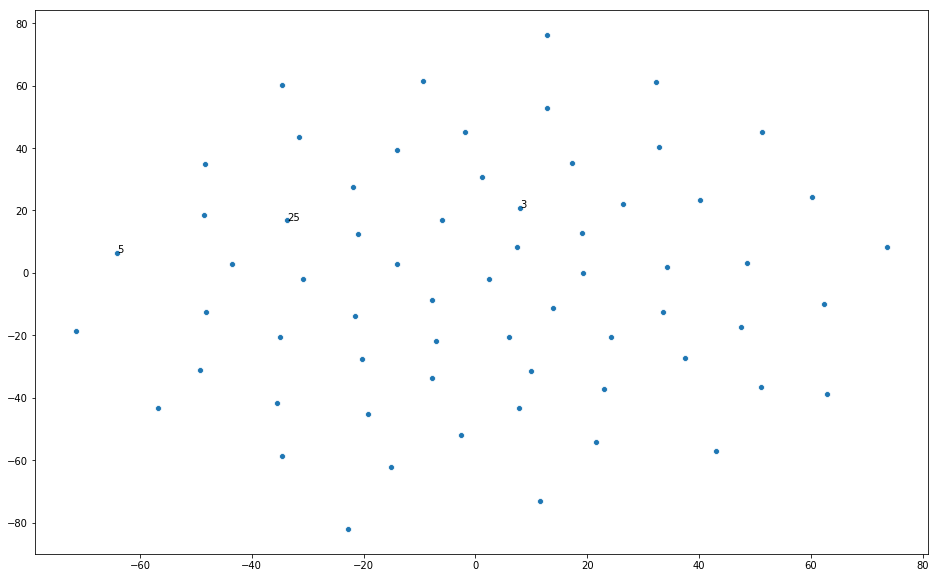

In [8]:
import seaborn as sns
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    legend="full",)
def label_point(x, y, ax):
    a = {}
    a['x'] = x
    a['y'] = y
    for i in range(x.size):
        if(i == z1 or i == z2 or i == z3):
            ax.text(a['x'][i]+.02, a['y'][i], i)

        

label_point(tsne_results[:,0], tsne_results[:,1], plt.gca())  


# interpolate

sample interpolation

function to generate object by given z-vector

In [9]:
from scipy.optimize import minimize
z_vector = tf.placeholder(shape=[batch_size, z_size], dtype=tf.float32)
saver = tf.train.Saver()
net_g_test = generator(z_vector, phase_train=False, reuse=True)
def get_obj_by_z(z):
    retval = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, trained_model_path)
        retval = sess.run(net_g_test, feed_dict={z_vector: z})

    return retval


G1:  Tensor("gen_1/Relu:0", shape=(32, 4, 4, 4, 512), dtype=float32)
G2:  Tensor("gen_1/Relu_1:0", shape=(32, 8, 8, 8, 256), dtype=float32)
G3:  Tensor("gen_1/Relu_2:0", shape=(32, 16, 16, 16, 128), dtype=float32)
G4:  Tensor("gen_1/Relu_3:0", shape=(32, 32, 32, 32, 64), dtype=float32)
G5:  Tensor("gen_1/Tanh:0", shape=(32, 64, 64, 64, 1), dtype=float32)


# define stepsize and vectors to be interpolated

In [12]:
step_size = 32
source_z = np.asarray(z_out[z2])
dest_z = np.asarray(z_out[z1])

objects = get_obj_by_z([(source_z*i/step_size+dest_z*(step_size-i)/step_size) for i in range(0,step_size) ])

[21/May/2019 20:42:52] INFO - Restoring parameters from ./GAN/models/biasfree_tfbn.ckpt-18400


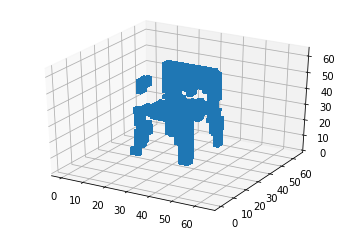

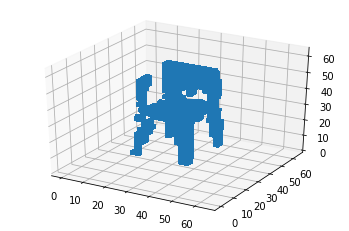

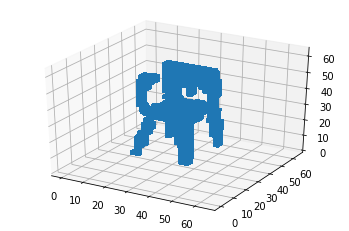

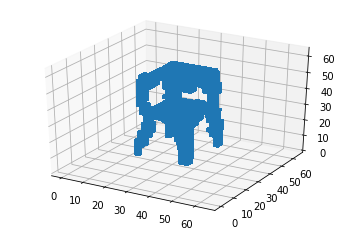

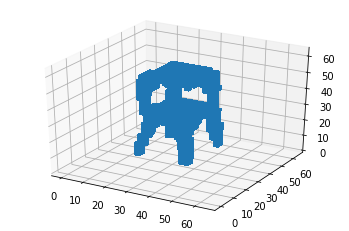

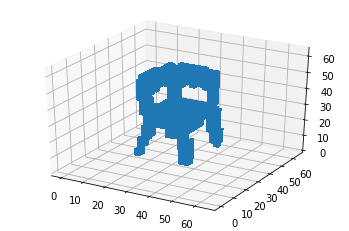

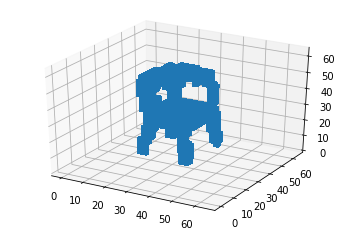

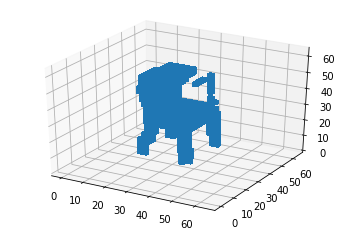

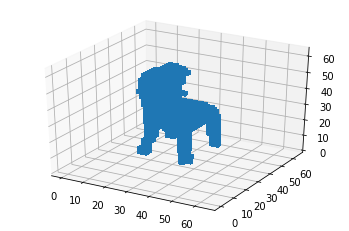

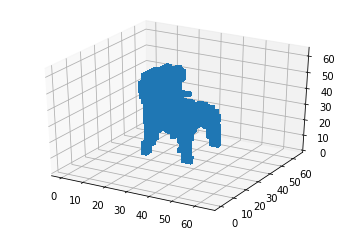

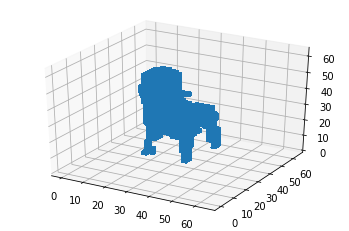

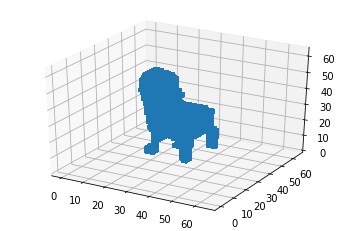

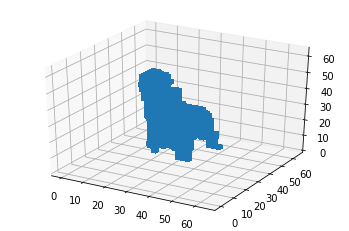

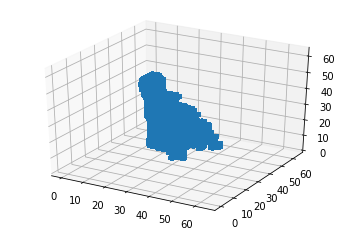

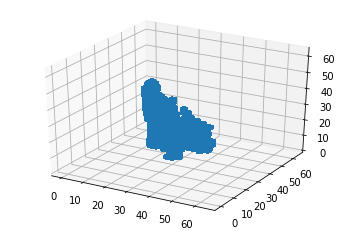

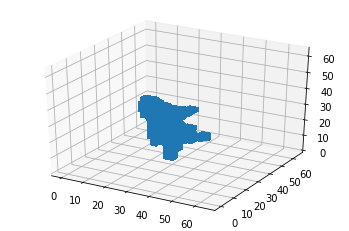

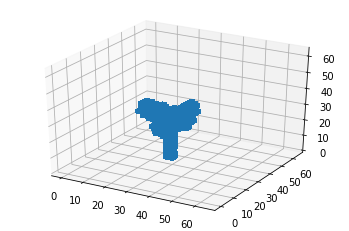

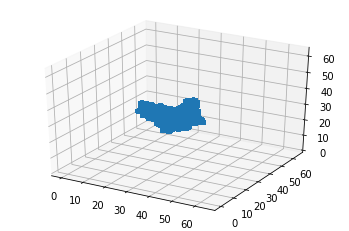

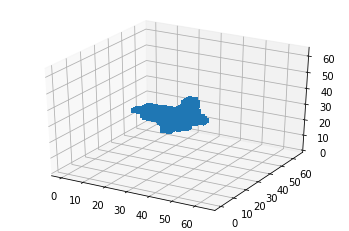

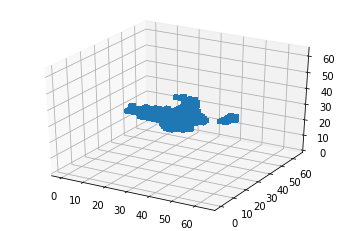

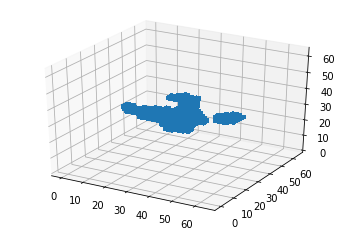

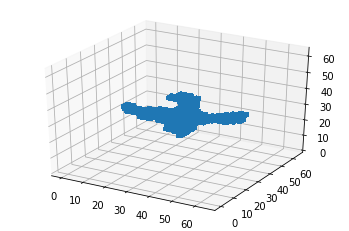

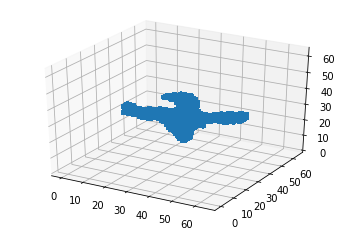

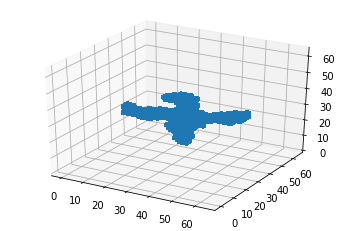

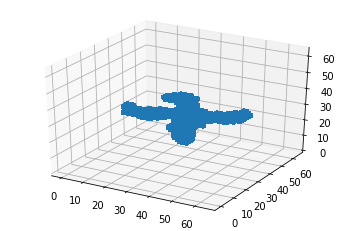

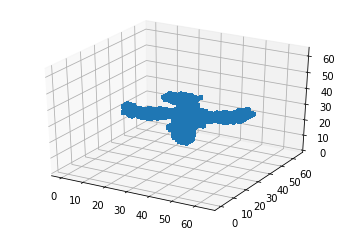

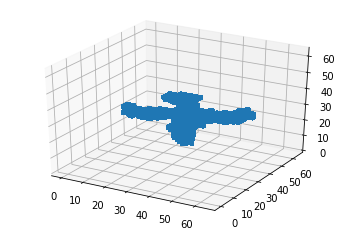

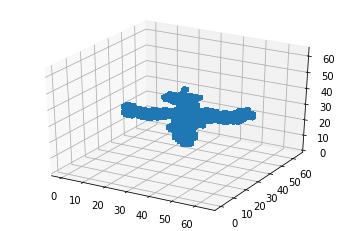

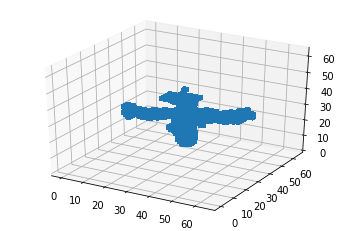

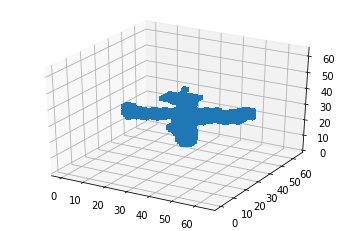

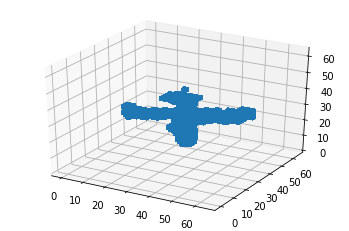

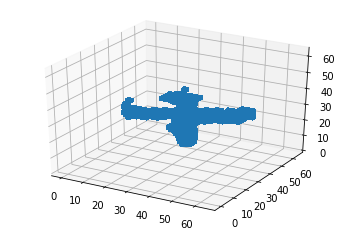

In [11]:
for i in range(0, step_size):
    plot(objects[i].reshape(64,64,64))